# Time Series Analysis 

Decided to do a quick analysis of Construction Spending and Total Households in the US. It's a small dataset, because we have only yearly datapoints, but I hypothesize that they will be strongly related. 

My analysis includes 

1. Datasets Explained
2. Cleaning & Initial Visualization
3. Stationarity Tests - ADFuller and KPSS
4. Transformation to Stationary data - difference method
5. Vector Autoregressive Model
6. Durbin-Watson  Statistic to check for Autoregression
7. Granger-Causality Analysis
8. Conclusions!

# Construction spending explained:

https://www.census.gov/construction/c30/definitions.html

Observation Start: 2001

Observation End : 2019

Frequency: Monthly

Construction includes the following:

1. New buildings and structures.

2. Additions, alterations, conversions, expansions, reconstruction, renovations, rehabilitations, and major replacements (such as the complete replacement of a roof or heating system).

3. Mechanical and electrical installations

4. Site preparation and outside construction of fixed structures or facilities such as sidewalks, highways and streets, parking lots, etc. 

5. Installation of boilers, overhead hoists and cranes, and blast furnaces.

6. Fixed, largely site-fabricated equipment not housed in a building,like storage tanks, refrigeration systems, etc.

7. Cost and installation of construction materials 

VALUE OF CONSTRUCTION PUT IN PLACE
The “value of construction put in place” is a measure of the value of construction installed or erected at the site during a given period. For an individual project, this includes—

1. Cost of materials installed or erected, Cost of labor, Contractor’s profit, Cost of architectural and engineering work, Miscellaneous overhead and office costs chargeable to the project on the owner’s books and Interest and taxes paid during construction (except for state and locally owned projects).

The total value-in-place for a given period is the sum of the value of work done on all projects underway during this period. 

CLASSIFICATION OF CONSTRUCTION
The downloaded dataset only looks at the Residential Construction, which inclues: 

Residential Buildings
New single family
New multi-family
Includes new apartments and condominiums. 

State and local includes remodeling, additions, and major replacements, the addition of swimming pools and garages, and replacement of major equipment items such as water heaters. Maintenance and repair work is excluded.

Includes remodeling, additions, and major replacements, includes construction of additional housing units in existing residential structures,  Maintenance and repair work is not included.




# Household Dataset Facts:
Observation Start: 1940-01-01

Observation End : 2019-01-01

Frequency: Yearly


Household is an occupied housing unit.
Householder is a person in whose name the housing unit is rented or owned. This person must be at least 15 years old.
Family household is a household in which there is at least 1 person present who is related to the householder by birth, marriage or adoption.
Family is used to refer to a family household. In general, family consists of those related to each other by birth, marriage or adoption.

This data uses the householder's person weight to describe characteristics of people living in households. As a result, estimates of the number of households do not match estimates of housing units from the Housing Vacancy Survey (HVS). The HVS is weighted to housing units, rather than the population, in order to more accurately estimate the number of occupied and vacant housing units. For more information about the source and accuracy statement of the Annual Social and Economic Supplement (ASEC) of the Current Population Survey (CPS) see the technical documentation accessible at: http://www.census.gov/programs-surveys/cps/technical-documentation/complete.html

## Import and Clean

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

households = pd.read_csv('/kaggle/input/total-households-time-series/TTLHH.csv')
nRow, nCol = households.shape
print(f'There are {nRow} rows and {nCol} columns in the households dataset')

#the ID for the  file on residential spending can be found in the residential metadata: total-construction-spending-residential_metadata.json 
#using the seasonally adjusted rate?
construction = pd.read_csv('/kaggle/input/total-construction-spending-data-collection/TLNRESCONS.csv')
nRow, nCol = construction.shape
print(f'There are {nRow} rows and {nCol} columns in the construction dataset')


There are 80 rows and 4 columns in the households dataset
There are 213 rows and 4 columns in the construction dataset


In [2]:
#CLEANING

households = households.replace('.', 0)
households = households.astype({'value': float})
households['date'] = pd.to_datetime(households['date'])
households = households.loc[households['date']>('2001-01-01')]

households.head()

,realtime_start,value,date,realtime_end
62,2019-12-06,109297.0,2002-01-01,2019-12-06
63,2019-12-06,111278.0,2003-01-01,2019-12-06
64,2019-12-06,112000.0,2004-01-01,2019-12-06
65,2019-12-06,113343.0,2005-01-01,2019-12-06
66,2019-12-06,114384.0,2006-01-01,2019-12-06


In [3]:
#Lining UP
construction.dtypes
construction['date'] = pd.to_datetime(construction['date'])
construction['Month'] = construction['date'].dt.month 
construction_yr = construction.loc[construction['Month'] ==1]
construction_yr.tail()

,realtime_start,value,date,realtime_end,Month
156,2019-11-04,655130,2015-01-01,2019-11-04,1
168,2019-11-04,713009,2016-01-01,2019-11-04,1
180,2019-11-04,741550,2017-01-01,2019-11-04,1
192,2019-11-04,738634,2018-01-01,2019-11-04,1
204,2019-11-04,767598,2019-01-01,2019-11-04,1


In [4]:
construction_yr.tail()

,realtime_start,value,date,realtime_end,Month
156,2019-11-04,655130,2015-01-01,2019-11-04,1
168,2019-11-04,713009,2016-01-01,2019-11-04,1
180,2019-11-04,741550,2017-01-01,2019-11-04,1
192,2019-11-04,738634,2018-01-01,2019-11-04,1
204,2019-11-04,767598,2019-01-01,2019-11-04,1


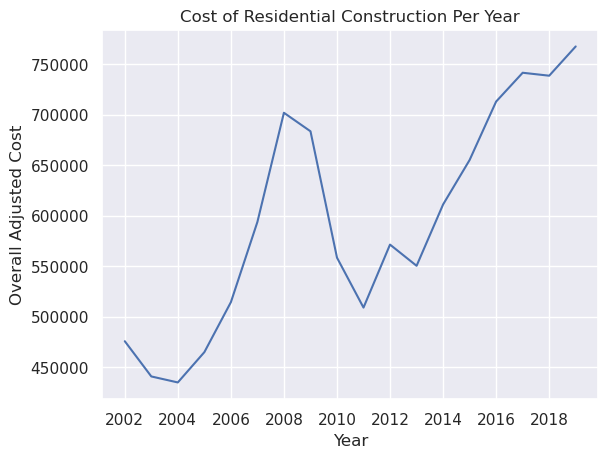

In [5]:
import seaborn as sns
sns.set_theme()
plt = sns.lineplot(data=construction_yr, x="date", 
             y="value").set(title="Cost of Residential Construction Per Year",
                           xlabel="Year",ylabel="Overall Adjusted Cost")

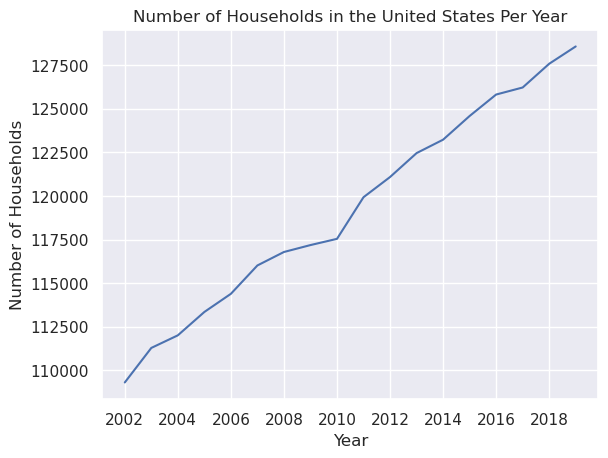

In [6]:
g = sns.lineplot(data=households, x="date", y="value", 
                 markers = True).set(title="Number of Households in the United States Per Year",
                                    xlabel='Year', ylabel='Number of Households')


## AD Fuller Test 

We want to see if our time series is stationary.  Hopefully it is - meaning that there are no time-dependent trends or seasons. If not, we have to transform it so that it is.

    Null Hypothesis: If this fails to be rejected, it suggests the time series is not stationary

    Alternate Hypothesis: If the null hypothesis is rejected, it suggests the time series is stationary

In [7]:
from statsmodels.tsa.stattools import adfuller

def ad_fuller(df_col):
    adfuller_result = adfuller(df_col)
    print("Test Statistic: " + str(adfuller_result[0]))
    print("p-value: " + str(adfuller_result[1]))

In [8]:
ad_fuller(households['value'])

Test Statistic: 0.8798470650556813
p-value: 0.9928216077260427


In [9]:
ad_fuller(construction_yr['value'])

Test Statistic: 2.083288342279014
p-value: 0.9987718682000956


Since the p-value is not less than .05, we fail to reject the null hypothesis. This means the time series is non-stationary. In other words, it has some time-dependent structure and does not have constant variance over time.

Next, we use a second and more sophistocated test to see if the time series are stationary.


## KPSS Test 

The KPSS test figures out if a time series is stationary around a mean or linear trend, or is non-stationary due to a unit root.

Null hypothesis: The time series is stationary

Alternative hypothesis: The time series is not stationary

In [10]:
from statsmodels.tsa.stattools import kpss

def kpss_test(df):    
    statistic, p_value, n_lags, critical_values = kpss(df.values)
    
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')

kpss_test(construction_yr['value'])
print("the p-value is less than 0.05, so we can reject the null hypothesis. This suggests the time series is not stationary")

KPSS Statistic: 0.5155202784550094
p-value: 0.038171108456078975
num lags: 2
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
the p-value is less than 0.05, so we can reject the null hypothesis. This suggests the time series is not stationary


In [11]:
kpss_test(households['value'])
print("the p-value is less than 0.05, so we can reject the null hypothesis. This suggests the time series is not stationary")

KPSS Statistic: 0.7068402824700176
p-value: 0.01292361068454385
num lags: 2
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
the p-value is less than 0.05, so we can reject the null hypothesis. This suggests the time series is not stationary


The ADF and KPSS test agree - these time series are not stationary. Therefore, we must transform them to continue this analysis.  

## Transform Time Series: Difference Method

Differencing is a method of transforming a time series dataset.

It can be used to remove the series dependence on time, so-called temporal dependence. This includes structures like trends and seasonality.

Differencing is performed by subtracting the previous observation from the current observation.

In [12]:
construction_yr['diff_value'] = construction_yr.value.diff().dropna()
households['diff_value'] = households.value.diff().dropna()
construction_yr = construction_yr[1:] #chop off the NaN created at the beginning of the dataframe
households = households[1:]

/tmp/ipykernel_20/379163744.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  construction_yr['diff_value'] = construction_yr.value.diff().dropna()


In [13]:
construction_yr.head()

,realtime_start,value,date,realtime_end,Month,diff_value
12,2019-11-04,440816,2003-01-01,2019-11-04,1,-34888.0
24,2019-11-04,434867,2004-01-01,2019-11-04,1,-5949.0
36,2019-11-04,464914,2005-01-01,2019-11-04,1,30047.0
48,2019-11-04,514379,2006-01-01,2019-11-04,1,49465.0
60,2019-11-04,593821,2007-01-01,2019-11-04,1,79442.0


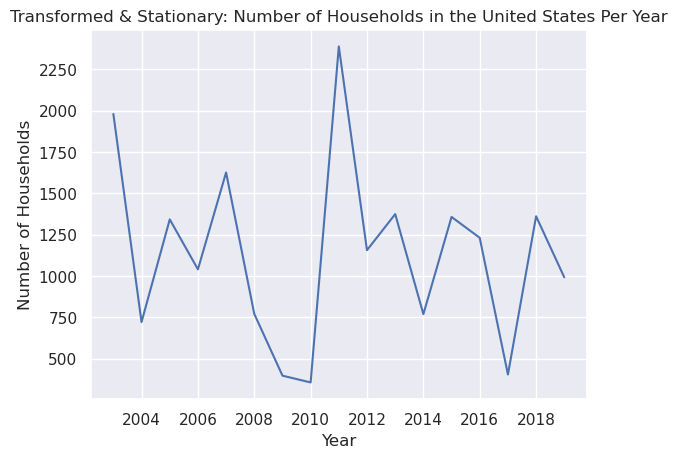

In [14]:
g = sns.lineplot(data=households, x="date", y="diff_value", 
                 markers = True).set(title="Transformed & Stationary: Number of Households in the United States Per Year",
                                    xlabel='Year', ylabel='Number of Households')


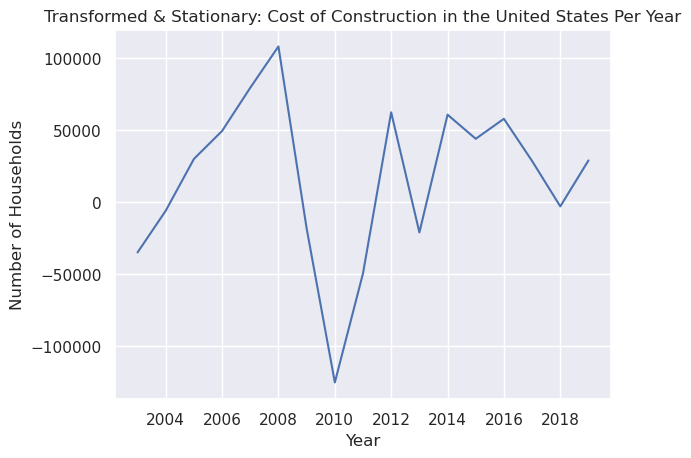

In [15]:
g = sns.lineplot(data=construction_yr, x="date", y="diff_value", 
                 markers = True).set(title="Transformed & Stationary: Cost of Construction in the United States Per Year",
                                    xlabel='Year', ylabel='Number of Households')


In [16]:
print("~~~~ AD FULLER TEST ~~~~")
ad_fuller(construction_yr['diff_value']) # the time series is not stationary
print("~~~~ KPSS TEST ~~~~")
kpss_test(construction_yr['diff_value']) # the time series is stationary

~~~~ AD FULLER TEST ~~~~
Test Statistic: -2.774316420206624
p-value: 0.0620371723693255
~~~~ KPSS TEST ~~~~
KPSS Statistic: 0.07066370032730576
p-value: 0.1
num lags: 1
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [17]:
print("~~~~ AD FULLER TEST ~~~~")
ad_fuller(households['diff_value'])#the time series is stationary
print("~~~~ KPSS TEST ~~~~")
kpss_test(households['diff_value'])#the time series is stationary

~~~~ AD FULLER TEST ~~~~
Test Statistic: -5.246328795455623
p-value: 7.066187147307745e-06
~~~~ KPSS TEST ~~~~
KPSS Statistic: 0.10799608849740581
p-value: 0.1
num lags: 2
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


There is some disagreements among the tests - for the construction dataset, the AD Fuller test indicated that the dataset was not stationary, however the KPSS test said otherwise.  For the households test, it seems that both tests indicated the data was stationary.

## Vector Autoregressive (VAR) Model

This model relates current observations of a model to past observations of itself. The VAR  assumes that the passed time series are stationary. 

First, we concat the two timeseries into one dataframe:

In [18]:
households_small = households[['date','diff_value']]
construction_small = construction_yr[['date','diff_value']]
df_complete = households_small.join(construction_small.set_index('date'), on='date',lsuffix='_households', rsuffix='_construction')
df = df_complete[['diff_value_households','diff_value_construction']]
df_complete.head()

,date,diff_value_households,diff_value_construction
63,2003-01-01,1981.0,-34888.0
64,2004-01-01,722.0,-5949.0
65,2005-01-01,1343.0,30047.0
66,2006-01-01,1041.0,49465.0
67,2007-01-01,1627.0,79442.0


In [19]:
from statsmodels.tsa.api import VAR

model = VAR(df)

for i in [1,2,3,4]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  33.73989965862769
BIC :  34.02962042946761
FPE :  453891319992856.25
HQIC:  33.75473573903136 

Lag Order = 2
AIC :  33.616021738426
BIC :  34.08805520582747
FPE :  419038017746278.7
HQIC:  33.610993595694524 

Lag Order = 3
AIC :  32.114400498050806
BIC :  32.75345782766606
FPE :  107835180985512.88
HQIC:  32.05524406060554 

Lag Order = 4
AIC :  32.00294001433949
BIC :  32.78517758620931
FPE :  150232532986691.28
HQIC:  31.84215497210349 



/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [20]:
results = model.fit(maxlags=4, ic='aic')
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 07, Jul, 2023
Time:                     20:48:55
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    32.7852
Nobs:                     13.0000    HQIC:                   31.8422
Log likelihood:          -226.912    FPE:                1.50233e+14
AIC:                      32.0029    Det(Omega_mle):     5.24572e+13
--------------------------------------------------------------------
Results for equation diff_value_households
                                coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------------
const                          10236.518696      4609.699326            2.221           0.026
L1.diff_value_households          -2.609991         1.116317           -2.338         

The correlation is quite large between the amount of households  and the amount of residential construction. That is what I expected. It also looks like a lag of 4 is optimal, as it minimizes the AIC, BIC and HQ. 

## Durbin-Watson Statistic

The Durbin Watson Test is a measure of autocorrelation in residuals from regression analysis.

The value of d always lies between 0 and 4. If the Durbin–Watson statistic is substantially less than 2, there is evidence of positive serial correlation. As a rough rule of thumb, if Durbin–Watson is less than 1.0, there may be cause for alarm. Small values of d indicate successive error terms are positively correlated. If d > 2, successive error terms are negatively correlated. 

In [21]:
from statsmodels.stats.stattools import durbin_watson

out = durbin_watson(results.resid)

for col, val in zip(df.columns, out):
    print(col, ':', round(val, 2))

diff_value_households : 2.96
diff_value_construction : 2.76


There is no strong indication of autocorrelation in the above variables. 

## Granger Causality Test



In [22]:
from statsmodels.tsa.stattools import grangercausalitytests

maxlag=4
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
   
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)

,diff_value_households_x,diff_value_construction_x
diff_value_households_y,1.0,0.0
diff_value_construction_y,0.0,1.0


The above code was taken from an article on towardsdatascience

[https://towardsdatascience.com/a-quick-introduction-on-granger-causality-testing-for-time-series-analysis-7113dc9420d2].

The row are the response (y) and the columns are the predictors (x). If a given p-value is < significance level (0.05), for example, take the value 0.0 in (row 1, column 2), we can reject the null hypothesis and conclude that walmart_x Granger causes apple_y. Likewise, the 0.0 in (row 2, column 1) refers to walmart_y Granger causes apple_x.

All the time series in the above data are interchangeably Granger causing each other.



## Conclusion

The data here is weak to begin with, as only one datapoint per year is being analyzed over 16 years. That being said, the analysis did show us what I expected - that construction cost and number of households in the US are strongly related. They pass the Granger causality test both ways - suggesting that they both have influence on each other.  That makes a lot of sense - the construction data includes cost of renovations and major improvements.  So, as the number of households increases, so does the opportunity for construction. In the other direction, construction being done in a residential setting could lead to a new household in the future. 



